In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
from trasim_simplified.core.constant import CFM
from trasim_simplified.core.kinematics.cfm.CFModel_IDM import cf_IDM_acc_module, cf_IDM_equilibrium_module

dt = 0.1
cf_name = CFM.IDM
cf_func = cf_IDM_acc_module
cf_e = cf_IDM_equilibrium_module
if cf_name == CFM.IDM:
    param_names = ["s0", "v0", "T", "omega", "d", "delta"]
elif cf_name == CFM.ACC:
    param_names = ["k1", "k2", "thw", "s0"]
else:
    raise ValueError("cf_name error")

# 读取数据

In [5]:
from trasim_simplified.util.tools import load_from_pickle
from trasim_simplified.core.constant import TrackInfo as TI, Prefix

# 读取轨迹数据
traj_s_full_clb: dict[str, dict[str, pd.DataFrame]] = load_from_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_traj_s" + f"_{cf_name}.pkl")
traj_s_cut_pos = {v_id: len(df_pair) for v_id, df_pair in traj_s_full_clb["dec"].items()}

traj_s_full: dict[str, pd.DataFrame] = {v_id: pd.concat([df_pair, traj_s_full_clb["acc"][v_id]]) for v_id, df_pair in traj_s_full_clb["dec"].items()}
clb_x_s = [traj_s_full[k][TI.x] for k in traj_s_full.keys()]
clb_v_s = [traj_s_full[k][TI.v] for k in traj_s_full.keys()]
obs_lx_s = [traj_s_full[k][Prefix.leader + TI.x] for k in traj_s_full.keys()]
obs_lv_s = [traj_s_full[k][Prefix.leader + TI.v] for k in traj_s_full.keys()]
leaderL_s = [traj_s_full[k][Prefix.leader + TI.v_Length].unique()[0] for k in traj_s_full.keys()]
id_s = [k for k in traj_s_full.keys()]
assert len(id_s) == len(set(id_s))
print(len(id_s))

# 读取标定参数
param_df: pd.DataFrame = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\clb_dec_acc_param_df" + f"_{cf_name}.pkl")
param_df

320


,s0,v0,T,omega,d,delta,Pair_ID,ObjV
0,5.263910,49.999962,1.541605,1.320260,8.627592,10.0,192,11.514163
1,3.644018,12.264595,0.733242,1.753525,9.999924,10.0,195,9.598012
2,5.456839,13.373985,1.240511,2.796910,6.160598,10.0,196,7.231744
3,6.034975,15.261345,1.485023,1.830330,10.000000,7.0,197,17.875899
4,4.335928,14.275742,1.358891,2.036001,2.749949,10.0,199,11.664526
...,...,...,...,...,...,...,...,...
315,0.000000,35.447350,1.765614,5.206991,1.219058,1.0,6216,10.668306
316,2.136602,39.901276,0.310650,1.500203,0.970608,1.0,6394,17.509274
317,2.732277,26.479301,1.212530,1.613764,8.744552,10.0,6395,6.639412
318,2.590122,16.543350,1.469288,2.777980,10.000000,3.0,6417,19.415002


In [7]:
from trasim_simplified.util.calibrate.clb_cf_model import cf_param_types

cf_param = param_df[param_names].describe().loc["mean"].to_dict()
cf_param = {param_name: (round(cf_param[param_name]) if cf_param_types[cf_name][param_name] == 1 else cf_param[param_name]) for param_name in param_names}
cf_param

Using geatpy


{'s0': 4.1008338034152985,
 'v0': 26.327823400497437,
 'T': 1.0647761225700378,
 'omega': 2.4786814156174657,
 'd': 5.083119785487652,
 'delta': 6}

In [22]:
from trasim_simplified.util.hysteresis.sim_scenario import slow_to_go_sim
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity


def single_run(cf_func_, cf_param_, cf_e_):
    dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_ = slow_to_go_sim(cf_func_, cf_param_, cf_e=cf_e_, warmup_time=100, dec_time=10, slow_time=100, acc_time=10, hold_time=100, init_v=10, dv=5)
    vs_results = cal_sv_intensity(dec_s_, dec_v_, acc_s_, acc_v_, cf_e_, cf_param_)
    return {**cf_param_, **vs_results}, (dec_s_, dec_v_, acc_s_, acc_v_, dec_a_, acc_a_, dec_lv_, acc_lv_)

def IDM_v_module(omega, v0, delta, speed, **kwargs):
    return omega * (1 - np.power(speed / v0, delta))

def IDM_s_module(omega, s0, T, speed, gap, **kwargs):
    return np.sqrt(omega) * (s0 + speed * T) / gap

def IDM_z_module(d, speed, leaderV, gap, **kwargs):
    return speed * (speed - leaderV) / (2 * np.sqrt(d)) / gap

# 计算各模块加速度

E:\PyProject\car-following-model-test\trasim_simplified\core\kinematics\cfm\CFModel_IDM.py:151: RuntimeWarning: divide by zero encountered in scalar divide
  return k_space * (s0 + speed * T) / np.sqrt(k_speed * (1 - np.power(speed / v0, delta)))
E:\PyProject\car-following-model-test\trasim_simplified\util\hysteresis\intensity.py:14: RuntimeWarning: invalid value encountered in scalar multiply
  area += (x_array[i + 1] - x_array[i]) * (y_array[i + 1] + y_array[i]) / 2
E:\PyProject\car-following-model-test\trasim_simplified\core\kinematics\cfm\CFModel_IDM.py:145: RuntimeWarning: invalid value encountered in scalar divide
  return k_speed * omega * (1 - np.power(speed / v0, delta)) - omega * np.power(sStar / gap, 2)


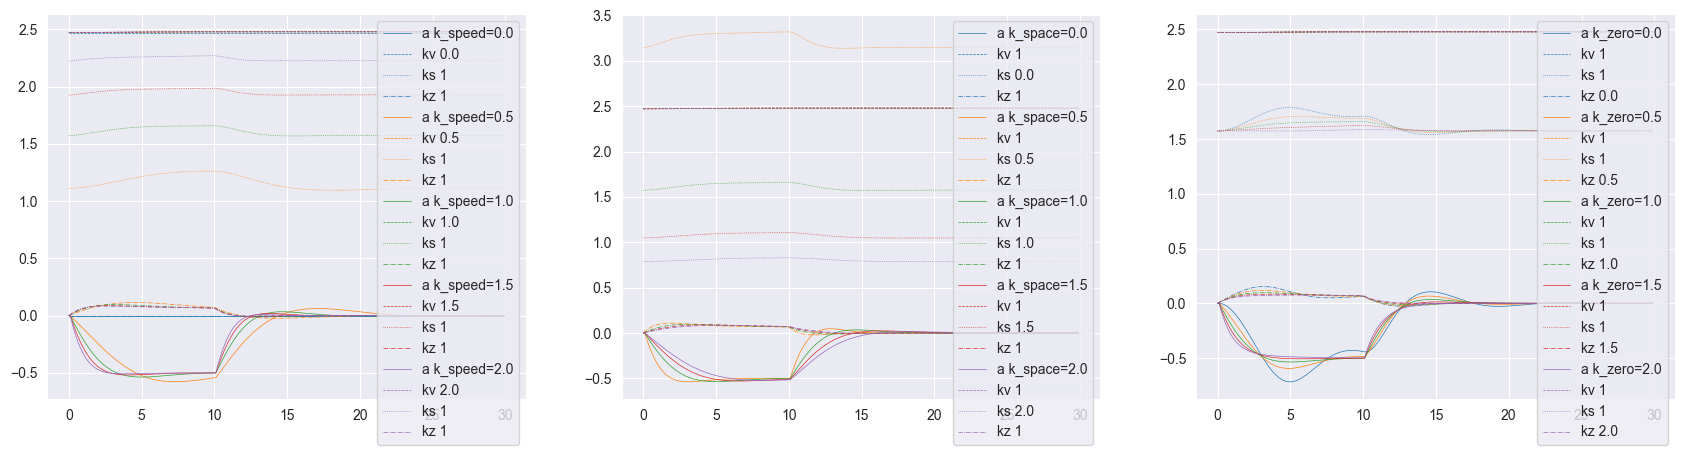

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(21, 5))
ax = ax.flatten()
ax: list[plt.Axes] = ax
fig: plt.Figure = fig

k_values = np.arange(0, 2.1, 0.5)
for i, k_type in enumerate(["k_speed", "k_space", "k_zero"]):
    cf_param_copy = cf_param.copy()
    for k_value in k_values:
        cf_param_copy.update({k_type: k_value})
        result, (dec_s, dec_v, acc_s, acc_v, dec_a, acc_a, dec_lv, acc_lv) = single_run(cf_func, cf_param_copy, cf_e)
        
        dec_steps = 300
        line_width = 0.5
        # 绘制模型加速度输出
        temp: list[plt.Line2D] = ax[i].plot(np.arange(len(dec_a[:dec_steps])) * 0.1, dec_a[:dec_steps], label=f"a {k_type}={k_value}", linewidth=line_width)
        
        # 绘制模块加速度输出
        time_full = np.arange(len(dec_v[:dec_steps])) * 0.1
        dec_kv = IDM_v_module(**cf_param_copy, speed=dec_v[:dec_steps])
        ax[i].plot(time_full, dec_kv, color=temp[-1].get_color(), linestyle="--", label=f"kv {cf_param_copy.get('k_speed', 1)}", linewidth=line_width)
        dec_ks = IDM_s_module(**cf_param_copy, speed=dec_v[:dec_steps], gap=dec_s[:dec_steps])
        ax[i].plot(time_full, dec_ks, color=temp[-1].get_color(), linestyle=":", label=f"ks {cf_param_copy.get('k_space', 1)}", linewidth=line_width)
        dec_kz = IDM_z_module(**cf_param_copy, speed=dec_v[:dec_steps], leaderV=dec_lv[:dec_steps], gap=dec_s[:dec_steps])
        ax[i].plot(time_full, dec_kz, color=temp[-1].get_color(), linestyle="-.", label=f"kz {cf_param_copy.get('k_zero', 1)}", linewidth=line_width)
        
        ax[i].legend()

fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change.svg")

In [13]:
from trasim_simplified.util.hysteresis.intensity import cal_sv_intensity
from trasim_simplified.core.constant import TrackInfo as TI

def single_traj_run(cf_func_, cf_e_, cf_param_, clb_v, clb_x, obs_lx, obs_lv, leaderL, pair_id, k_values):
    init_v = np.array(clb_v)[0]
    init_x = np.array(clb_x)[0]
    result_ = []
    res = None
    for k in k_values:
        cf_param_.update({"k_speed": k[0], "k_space": k[1], "k_zero": k[2]})
        sim_pos, sim_speed, sim_acc, sim_cf_acc = simulation(
            cf_func_,
            init_v=init_v,
            init_x=init_x,
            obs_lx=obs_lx, obs_lv=obs_lv, dt=dt,
            cf_param=cf_param_,
            leaderL=leaderL)
        dec_end_pos = traj_s_cut_pos[pair_id]
        res = cal_sv_intensity(
            dec_s=obs_lx[: dec_end_pos] - sim_pos[: dec_end_pos] - leaderL,
            dec_v=sim_speed[: dec_end_pos],
            acc_s=obs_lx[dec_end_pos:] - sim_pos[dec_end_pos: ] - leaderL,
            acc_v=sim_speed[dec_end_pos: ],
            cf_e=cf_e_,
            cf_param=cf_param_)
        result_.append([k[0], k[1], k[2], *list(res.values())])
    return result_, ["k_speed", "k_space", "k_zero"] + list(res.keys())

In [5]:
from trasim_simplified.core.kinematics.cfm import get_cf_default_param

cf_params = {pair_id: {name: param_df[param_df[TI.Pair_ID] == pair_id][name].iloc[0] for name in get_cf_default_param(cf_name).keys()} for pair_id in id_s}
cf_params

{0: {'v0': 40.223259353637694,
  's0': 2.7219676971435547,
  's1': -0.0,
  'delta': 3.0,
  'T': 1.9355392456054688,
  'omega': 1.2078510284423822,
  'd': 7.672030544281008},
 1: {'v0': 22.20983219146728,
  's0': 2.4691390991210938,
  's1': 0.0,
  'delta': 3.0,
  'T': 1.0486221313476562,
  'omega': 9.995505905151365,
  'd': 5.327264881134032},
 2: {'v0': 21.85220575332642,
  's0': 5.319366455078125,
  's1': 0.0,
  'delta': 4.0,
  'T': 0.7447624206542969,
  'omega': 10.0,
  'd': 1.1863058090209948},
 3: {'v0': 16.12889785766601,
  's0': 9.5367431640625e-06,
  's1': 0.0,
  'delta': 3.0,
  'T': 1.9796943664550781,
  'omega': 1.766204547882081,
  'd': 3.1259798049926744},
 4: {'v0': 42.23705549240112,
  's0': 2.7918624877929688,
  's1': -0.0,
  'delta': 1.0,
  'T': 0.7955074310302734,
  'omega': 4.016141033172606,
  'd': 10.0},
 5: {'v0': 50.0,
  's0': 6.323051452636719,
  's1': -0.0,
  'delta': 10.0,
  'T': 0.7451057434082031,
  'omega': 1.719611358642578,
  'd': 10.0},
 6: {'v0': 14.38440

In [6]:
from itertools import product
from trasim_simplified.util.calibrate.follow_sim import simulation
import joblib

pos = np.arange(0.1, 5.2, 0.5)
print(pos)
k_list = list(product(pos, pos, pos))
# for clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id in zip(clb_v_s, clb_x_s, obs_lx_s, obs_lv_s, leaderL_s, id_s):
#     single_traj_run(cf_func, cf_e, cf_params[v_id], clb_v, clb_x, obs_lx, obs_lv, leaderL, v_id, k_list)
#     print("OK")

result = joblib.Parallel(n_jobs=-1)(
    joblib.delayed(single_traj_run)(cf_func, cf_e, cf_params[pair_id], clb_v, clb_x, obs_lx, obs_lv, leaderL, pair_id, k_list) for clb_v, clb_x, obs_lx, obs_lv, leaderL, pair_id in zip(clb_v_s, clb_x_s, obs_lx_s, obs_lv_s, leaderL_s, id_s))
result[0]

[0.1 0.6 1.1 1.6 2.1 2.6 3.1 3.6 4.1 4.6 5.1]


([[0.1,
   0.1,
   0.1,
   13.02965627327492,
   85.9937587337832,
   99.02341500705813,
   23.343529690599972,
   126.28122018759075,
   77.86463445702611,
   0.36069938814192176,
   0.17255359778547266,
   4.157426007544549,
   7.174677491833518,
   3.269212620605169,
   9.25682246376107,
   5.9876098431559015,
   166,
   347],
  [0.1,
   0.1,
   0.6,
   9.137181261047045,
   57.72854694614185,
   66.8657282071889,
   9.259437117124648,
   78.94668175842507,
   50.28827348562974,
   0.328420538412738,
   0.1580582994666491,
   5.7353544182514495,
   8.385919183358805,
   4.966112614650271,
   10.450735606142995,
   5.484622991492724,
   167,
   347],
  [0.1,
   0.1,
   1.1,
   7.754226303971322,
   110.95771902880863,
   118.71194533277995,
   5.7887060175944525,
   102.75490669970102,
   67.63163240911418,
   0.23067598375638748,
   0.11035219972207586,
   6.005373515949181,
   6.802220189672508,
   5.054181769345249,
   8.883403099701281,
   3.8292213303560327,
   166,
   347],
  [

In [7]:
column_names = result[0][1]
result_df = pd.DataFrame(columns=column_names)

for i, pair_id in enumerate(id_s):
    temp_df = pd.DataFrame(np.array(result[i][0]), columns=column_names)
    temp_df[TI.Pair_ID] = pair_id
    result_df = pd.concat([result_df, temp_df], axis=0)
result_df

C:\Users\Enze Zhao\AppData\Local\Temp\ipykernel_17280\3331653761.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, temp_df], axis=0)


,k_speed,k_space,k_zero,dec_vs,acc_vs,total_vs,dec_ts,acc_ts,total_ts,dec_avg_acc,acc_avg_acc,dec_avg_speed,acc_avg_speed,min_speed,max_speed,dv,dec_step,acc_step,Pair_ID
0,0.1,0.1,0.1,13.029656,85.993759,99.023415,23.343530,126.281220,77.864634,0.360699,0.172554,4.157426,7.174677,3.269213,9.256822,5.987610,166.0,347.0,0.0
1,0.1,0.1,0.6,9.137181,57.728547,66.865728,9.259437,78.946682,50.288273,0.328421,0.158058,5.735354,8.385919,4.966113,10.450736,5.484623,167.0,347.0,0.0
2,0.1,0.1,1.1,7.754226,110.957719,118.711945,5.788706,102.754907,67.631632,0.230676,0.110352,6.005374,6.802220,5.054182,8.883403,3.829221,166.0,347.0,0.0
3,0.1,0.1,1.6,5.435735,139.807253,145.242988,4.375331,141.975229,95.200442,0.258600,0.121475,5.825043,4.759520,2.639952,6.855129,4.215178,163.0,347.0,0.0
4,0.1,0.1,2.1,2.687170,147.040215,149.727384,-0.883638,151.365709,140.129715,1.526977,0.123214,3.166197,4.301607,2.123087,6.398623,4.275535,28.0,347.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,5.1,5.1,3.1,1.157731,-0.318962,0.838769,2.110617,0.605363,-0.618052,0.574819,0.471163,3.878850,4.273229,0.000000,8.622283,8.622283,150.0,183.0,643.0
1327,5.1,5.1,3.6,2.434897,0.270171,2.705067,3.254653,1.447147,-0.748823,0.630639,0.552656,4.266698,4.263480,0.000000,10.279408,10.279408,163.0,186.0,643.0
1328,5.1,5.1,4.1,6.887629,-6.887629,0.000000,-0.186120,0.948655,0.567387,8.883179,8.883179,1.349733,0.000000,0.000000,0.888318,0.888318,1.0,1.0,643.0
1329,5.1,5.1,4.6,3.519644,4.979784,8.499429,6.421767,3.742990,-0.932195,0.663188,0.564803,4.195246,3.984146,0.000000,10.279408,10.279408,155.0,182.0,643.0


In [8]:
result_df.to_pickle(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result.pkl")
result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result.csv", index=False)

In [3]:
result_df = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result.pkl")
result_df

,k_speed,k_space,k_zero,dec_vs,acc_vs,total_vs,dec_ts,acc_ts,total_ts,dec_avg_acc,acc_avg_acc,dec_avg_speed,acc_avg_speed,min_speed,max_speed,dv,dec_step,acc_step,Pair_ID
0,0.1,0.1,0.1,13.029656,85.993759,99.023415,23.343530,126.281220,77.864634,0.360699,0.172554,4.157426,7.174677,3.269213,9.256822,5.987610,166.0,347.0,0.0
1,0.1,0.1,0.6,9.137181,57.728547,66.865728,9.259437,78.946682,50.288273,0.328421,0.158058,5.735354,8.385919,4.966113,10.450736,5.484623,167.0,347.0,0.0
2,0.1,0.1,1.1,7.754226,110.957719,118.711945,5.788706,102.754907,67.631632,0.230676,0.110352,6.005374,6.802220,5.054182,8.883403,3.829221,166.0,347.0,0.0
3,0.1,0.1,1.6,5.435735,139.807253,145.242988,4.375331,141.975229,95.200442,0.258600,0.121475,5.825043,4.759520,2.639952,6.855129,4.215178,163.0,347.0,0.0
4,0.1,0.1,2.1,2.687170,147.040215,149.727384,-0.883638,151.365709,140.129715,1.526977,0.123214,3.166197,4.301607,2.123087,6.398623,4.275535,28.0,347.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,5.1,5.1,3.1,1.157731,-0.318962,0.838769,2.110617,0.605363,-0.618052,0.574819,0.471163,3.878850,4.273229,0.000000,8.622283,8.622283,150.0,183.0,643.0
1327,5.1,5.1,3.6,2.434897,0.270171,2.705067,3.254653,1.447147,-0.748823,0.630639,0.552656,4.266698,4.263480,0.000000,10.279408,10.279408,163.0,186.0,643.0
1328,5.1,5.1,4.1,6.887629,-6.887629,0.000000,-0.186120,0.948655,0.567387,8.883179,8.883179,1.349733,0.000000,0.000000,0.888318,0.888318,1.0,1.0,643.0
1329,5.1,5.1,4.6,3.519644,4.979784,8.499429,6.421767,3.742990,-0.932195,0.663188,0.564803,4.195246,3.984146,0.000000,10.279408,10.279408,155.0,182.0,643.0


In [4]:
df_param_merge = pd.read_pickle(r"E:\PyProject\car-following-model-test\tests\data\df_param_hysteresis_merge.pkl")
df_param_merge

,s0,s1,v0,T,omega,d,delta,Pair_ID,ObjV,dec_vs,...,ori_total_ts,ori_dec_avg_acc,ori_acc_avg_acc,ori_dec_avg_speed,ori_acc_avg_speed,ori_min_speed,ori_max_speed,ori_dv,ori_dec_step,ori_acc_step
0,2.721968,-0.0,40.223259,1.935539,1.207851,7.672031,3.0,0,63.559033,5.305561,...,7.352020,0.613572,1.214749,6.670747,7.736697,1.532571e+00,13.558585,12.026015,196,99
1,2.469139,0.0,22.209832,1.048622,9.995506,5.327265,3.0,1,14.565089,-0.474472,...,-0.329252,0.586215,0.975248,6.671858,7.942776,1.549418e+00,12.277149,10.727731,183,110
2,5.319366,0.0,21.852206,0.744762,10.000000,1.186306,4.0,2,39.784665,-0.370032,...,-0.630023,0.511773,0.813353,6.163349,7.106439,1.558294e+00,10.667847,9.109553,178,112
3,0.000010,0.0,16.128898,1.979694,1.766205,3.125980,3.0,3,68.409334,4.301041,...,1.844770,0.599716,0.833752,5.738378,7.110131,1.530022e+00,11.785167,10.255145,171,123
4,2.791862,-0.0,42.237055,0.795507,4.016141,10.000000,1.0,4,25.099296,0.516129,...,0.100809,0.789064,0.289160,4.780465,4.107651,1.838766e-03,9.312796,9.310957,118,322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,1.592674,-0.0,23.573524,1.393871,2.331309,1.969307,3.0,639,14.176961,-3.331308,...,-0.838872,0.756700,0.635628,3.045036,5.154110,1.360412e-03,9.535779,9.534418,126,150
640,0.100231,0.0,24.008672,2.041454,1.973792,10.000000,2.0,640,32.962461,0.356737,...,1.455659,0.454954,0.427316,4.780745,5.008039,2.460510e-05,9.144591,9.144566,201,214
641,1.295023,-0.0,50.000000,0.487175,1.846598,1.873591,8.0,641,16.429270,0.230693,...,0.041163,0.426073,0.509531,5.144155,4.767966,2.200811e-06,9.884894,9.884892,232,194
642,2.806187,-0.0,18.838055,1.370878,2.840133,8.540486,2.0,642,19.417066,0.373866,...,0.896763,0.480512,0.457827,5.146290,5.532719,3.234391e-08,10.667365,10.667365,222,233


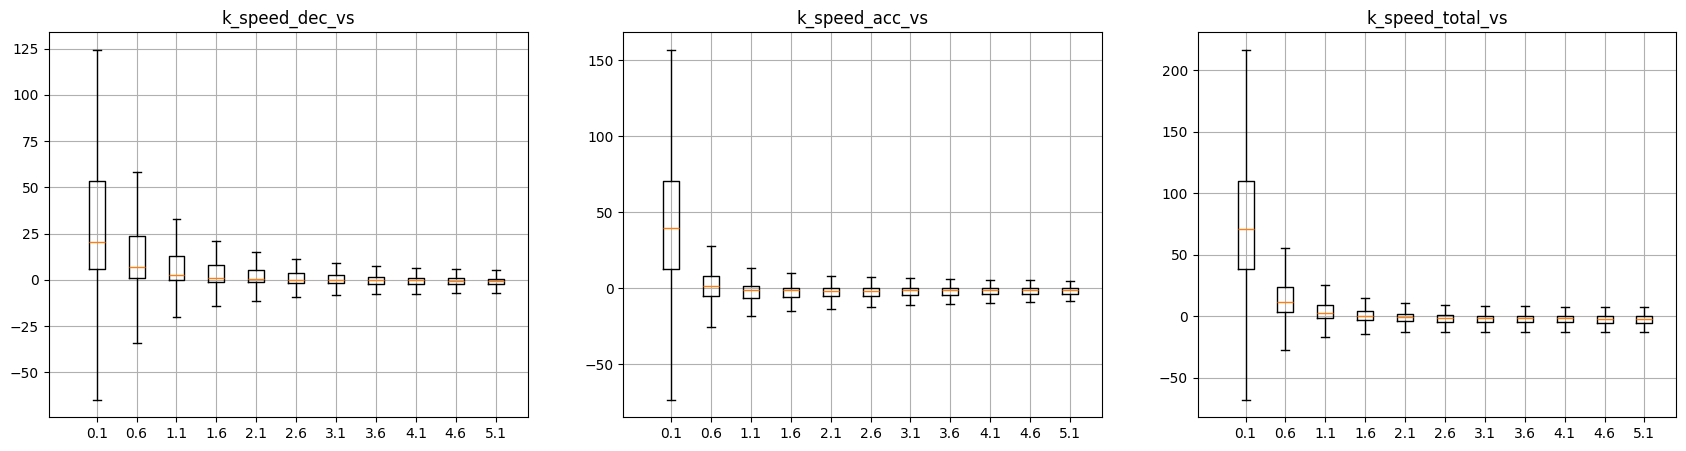

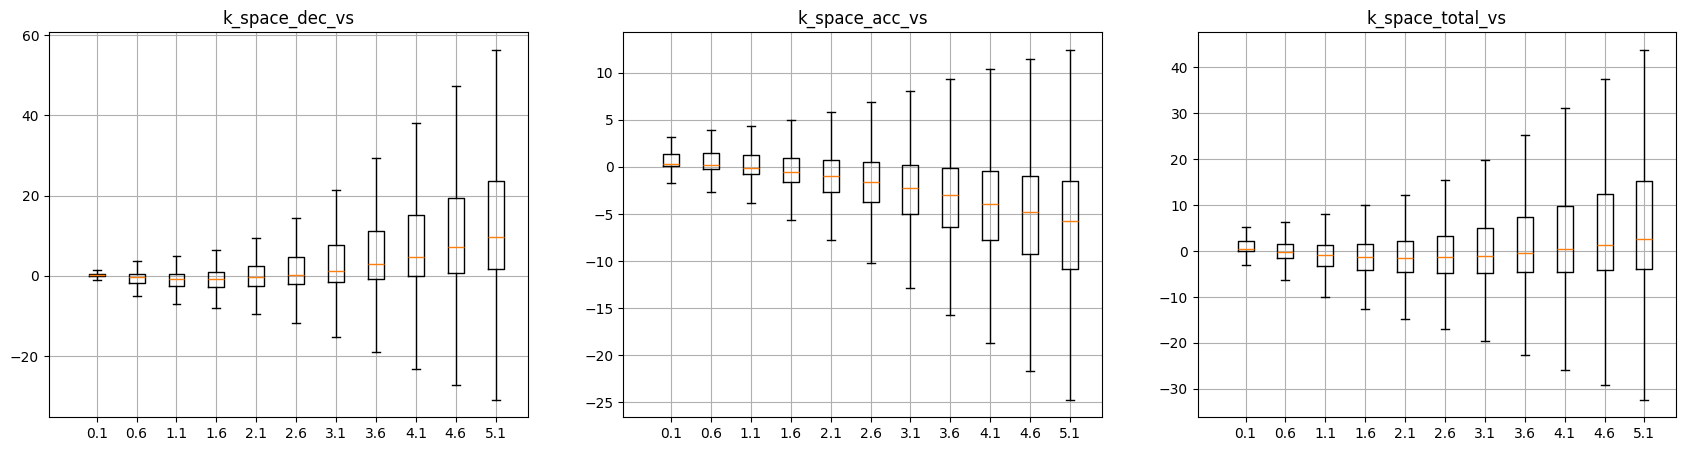

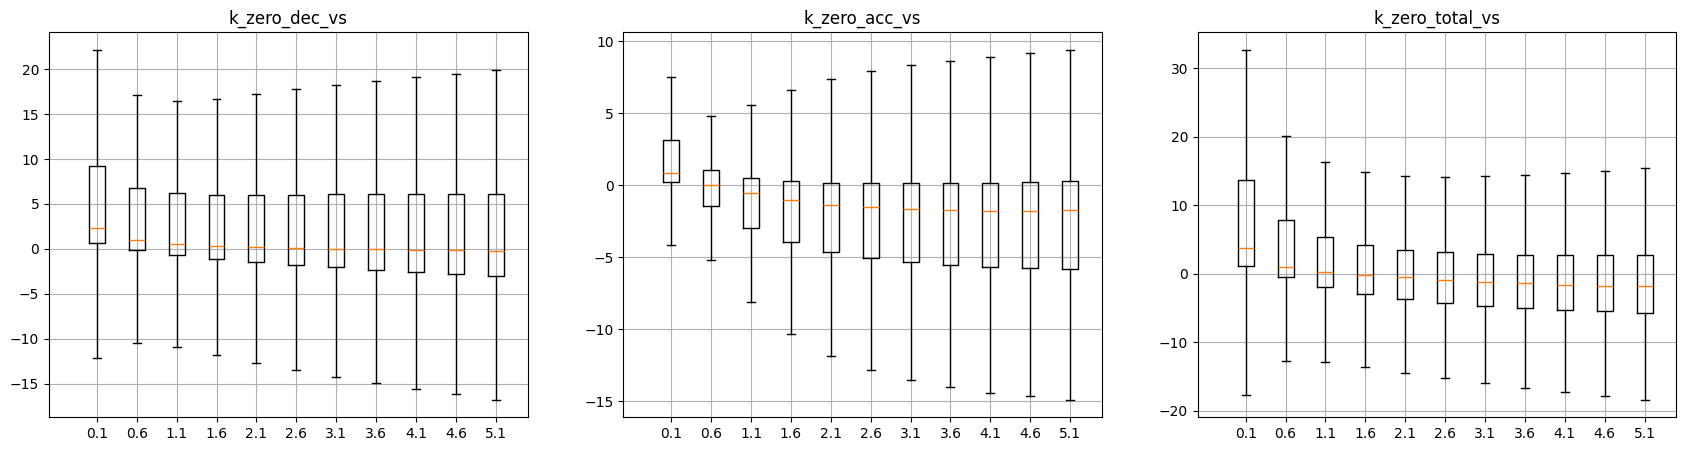

In [6]:
result_df = result_df[(np.isfinite(result_df["dec_vs"]) & np.isfinite(result_df["acc_vs"]))]
for k in ["k_speed", "k_space", "k_zero"]:
    temp: pd.DataFrame = result_df.groupby([k]).mean().reset_index()
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    axes: np.ndarray[plt.Axes] = axes
    # ax.plot(temp[k], temp["dec_vs"], label="dec_vs")
    # ax.plot(temp[k], temp["acc_vs"], label="acc_vs")
    # ax.plot(temp[k], temp["total_vs"], label="total_vs")
    
    for ax_, index in zip(axes, ["dec_vs", "acc_vs", "total_vs"]):
        ax_: plt.Axes = ax_
        ax_.boxplot([result_df[result_df[k] == i][index] for i in temp[k]], positions=temp[k], showfliers=False, widths=0.2)
        # ax_.set_xscale("log")
        # ax_.set_xticks(temp[k])
        ax_.set_xticklabels([f"{t:.1f}" for t in temp[k]])
        ax_.set_xlim([-0.5, 5.5])
        ax_.grid()
        ax_.set_title(k + "_" + index)
    fig.savefig(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_{}.png".format(k))
result_df.to_csv(r"E:\PyProject\car-following-model-test\tests\data\module_weight_change_result_infinite.csv", index=False)